In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from model import Model_1

In [2]:
# Train Phase transformations
train_transforms = transforms.Compose([

                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([

                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])

In [3]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

In [4]:
SEED = 1


cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)


torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)


dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)


train_loader = torch.utils.data.DataLoader(train, **dataloader_args)


test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? False


d:\ERA V2\ERA Rinkal Virtual enviroment\myenv\lib\site-packages\torchvision\datasets\mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(-0.4242)
 - max: tensor(2.8215)
 - mean: tensor(-0.0001)
 - std: tensor(1.0000)
 - var: tensor(1.0001)
torch.Size([64, 1, 28, 28])
torch.Size([64])


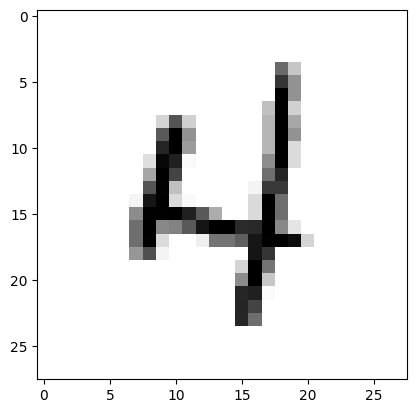

In [5]:

train_data = train.train_data
train_data = train.transform(train_data.numpy())

print('[Train]')
print(' - Numpy Shape:', train.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', train.train_data.size())
print(' - min:', torch.min(train_data))
print(' - max:', torch.max(train_data))
print(' - mean:', torch.mean(train_data))
print(' - std:', torch.std(train_data))
print(' - var:', torch.var(train_data))

dataiter = iter(train_loader)
images, labels = next(dataiter)

print(images.shape)
print(labels.shape)

# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')

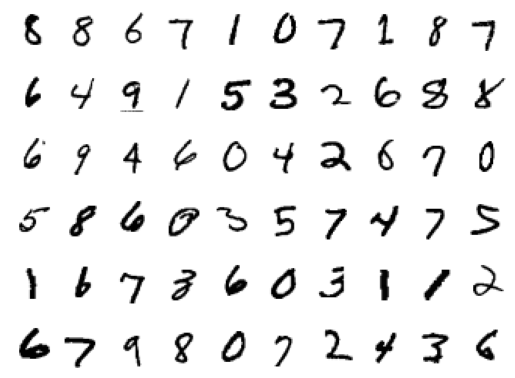

In [6]:
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

In [7]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Model_1().to(device)
summary(model, input_size=(1, 28, 28))

cpu
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 5, 26, 26]              45
       BatchNorm2d-2            [-1, 5, 26, 26]              10
              ReLU-3            [-1, 5, 26, 26]               0
            Conv2d-4           [-1, 10, 24, 24]             450
       BatchNorm2d-5           [-1, 10, 24, 24]              20
              ReLU-6           [-1, 10, 24, 24]               0
            Conv2d-7           [-1, 20, 22, 22]           1,800
       BatchNorm2d-8           [-1, 20, 22, 22]              40
              ReLU-9           [-1, 20, 22, 22]               0
        MaxPool2d-10           [-1, 20, 11, 11]               0
           Conv2d-11           [-1, 10, 11, 11]             200
      BatchNorm2d-12           [-1, 10, 11, 11]              20
             ReLU-13           [-1, 10, 11, 11]               0
           Conv2d-14             [-

In [8]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes.
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm

    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    test_acc.append(100. * correct / len(test_loader.dataset))

In [9]:
model =  Model_1().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

EPOCH: 0


  0%|          | 0/938 [00:00<?, ?it/s]

Loss=0.09671824425458908 Batch_id=937 Accuracy=96.18: 100%|██████████| 938/938 [00:37<00:00, 24.80it/s]  



Test set: Average loss: 0.0540, Accuracy: 9825/10000 (98.25%)

EPOCH: 1


Loss=0.014737262390553951 Batch_id=937 Accuracy=98.58: 100%|██████████| 938/938 [00:36<00:00, 25.38it/s] 



Test set: Average loss: 0.0365, Accuracy: 9877/10000 (98.77%)

EPOCH: 2


Loss=0.09284134209156036 Batch_id=937 Accuracy=98.90: 100%|██████████| 938/938 [00:37<00:00, 25.24it/s]  



Test set: Average loss: 0.0300, Accuracy: 9904/10000 (99.04%)

EPOCH: 3


Loss=0.004488565027713776 Batch_id=937 Accuracy=98.99: 100%|██████████| 938/938 [00:39<00:00, 23.67it/s] 



Test set: Average loss: 0.0323, Accuracy: 9890/10000 (98.90%)

EPOCH: 4


Loss=0.005693452898412943 Batch_id=937 Accuracy=99.16: 100%|██████████| 938/938 [00:36<00:00, 25.65it/s] 



Test set: Average loss: 0.0278, Accuracy: 9916/10000 (99.16%)

EPOCH: 5


Loss=0.0019320822320878506 Batch_id=937 Accuracy=99.30: 100%|██████████| 938/938 [00:36<00:00, 25.66it/s] 



Test set: Average loss: 0.0282, Accuracy: 9912/10000 (99.12%)

EPOCH: 6


Loss=0.001777984551154077 Batch_id=937 Accuracy=99.34: 100%|██████████| 938/938 [00:37<00:00, 24.93it/s]  



Test set: Average loss: 0.0252, Accuracy: 9917/10000 (99.17%)

EPOCH: 7


Loss=0.0011322896461933851 Batch_id=937 Accuracy=99.42: 100%|██████████| 938/938 [00:44<00:00, 21.13it/s] 



Test set: Average loss: 0.0219, Accuracy: 9931/10000 (99.31%)

EPOCH: 8


Loss=0.06278169900178909 Batch_id=937 Accuracy=99.46: 100%|██████████| 938/938 [00:43<00:00, 21.64it/s]   



Test set: Average loss: 0.0282, Accuracy: 9909/10000 (99.09%)

EPOCH: 9


Loss=0.00196756306104362 Batch_id=937 Accuracy=99.58: 100%|██████████| 938/938 [00:37<00:00, 24.71it/s]   



Test set: Average loss: 0.0270, Accuracy: 9914/10000 (99.14%)

EPOCH: 10


Loss=0.023700907826423645 Batch_id=937 Accuracy=99.58: 100%|██████████| 938/938 [00:37<00:00, 25.33it/s]  



Test set: Average loss: 0.0230, Accuracy: 9921/10000 (99.21%)

EPOCH: 11


Loss=0.05415372550487518 Batch_id=937 Accuracy=99.67: 100%|██████████| 938/938 [00:37<00:00, 25.31it/s]   



Test set: Average loss: 0.0250, Accuracy: 9922/10000 (99.22%)

EPOCH: 12


Loss=0.001888628350570798 Batch_id=937 Accuracy=99.68: 100%|██████████| 938/938 [00:36<00:00, 25.46it/s]  



Test set: Average loss: 0.0255, Accuracy: 9920/10000 (99.20%)

EPOCH: 13


Loss=0.0010633859783411026 Batch_id=937 Accuracy=99.72: 100%|██████████| 938/938 [00:44<00:00, 20.85it/s] 



Test set: Average loss: 0.0241, Accuracy: 9924/10000 (99.24%)

EPOCH: 14


Loss=0.0003370123158674687 Batch_id=937 Accuracy=99.75: 100%|██████████| 938/938 [01:03<00:00, 14.75it/s] 



Test set: Average loss: 0.0235, Accuracy: 9931/10000 (99.31%)



In [10]:
t = [t_items.item() for t_items in train_losses]

Text(0.5, 1.0, 'Test Accuracy')

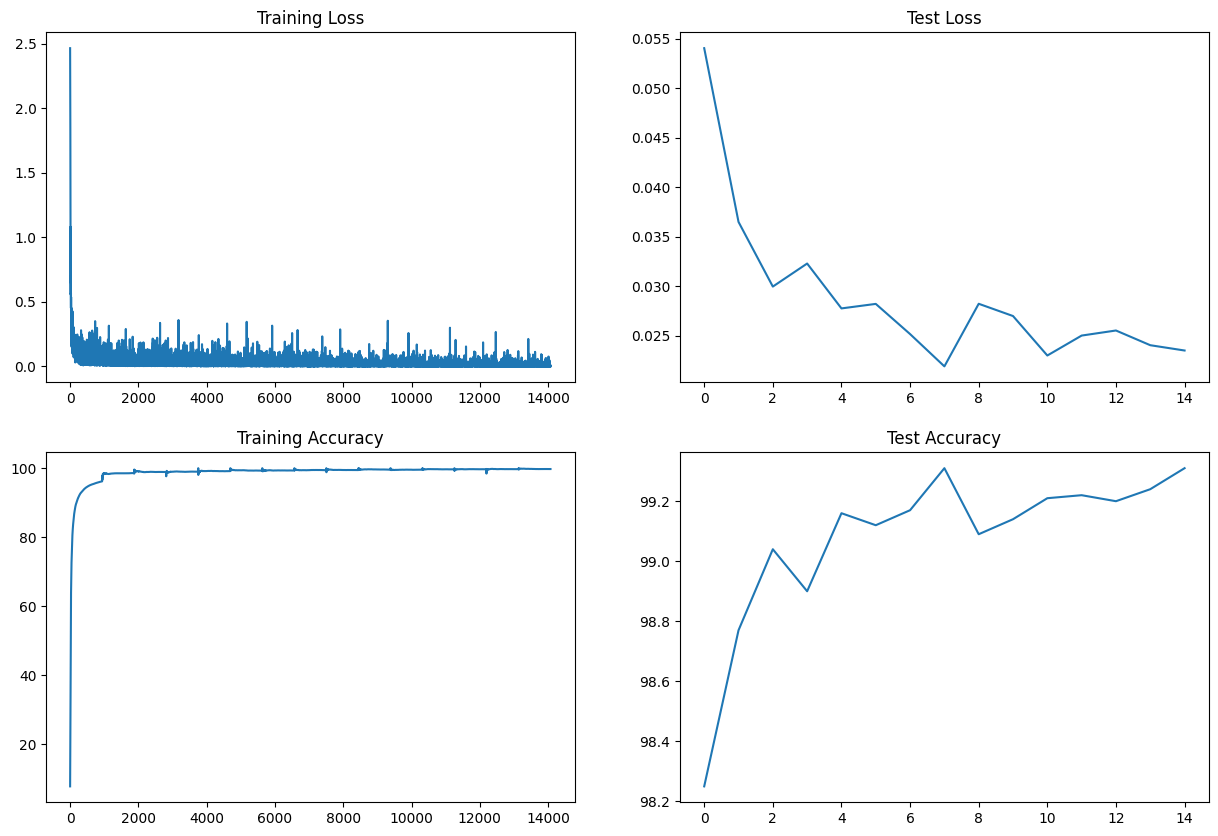

In [11]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(t)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

## Target:

1. Get the set-up right
2. Set Transforms
3. Set Data Loader
4. Set test and train loop
5. Set Basic Training  & Test Loop
6. Arranged to reduse the parameter


## Results:
1. Parameters: 11,145
2. Best Training Accuracy: 99.75
3. Best Test Accuracy: 99.31

## Analysis:
1. Even if the model is pushed further, it won't be able to get to 99.4
2. we have seen over-fitting in model, we are changing our model in the next step
 